Notebook to compute Utily with regressions with fixed effects

In [1]:
import sys
sys.path += ["../src"]
import utils
import config
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.pyplot import subplots as sbp 
from importlib import reload
import jl_vae
import pickle
from tqdm import tqdm
import geopandas as gpd
import pyfixest as pf
from sklearn.metrics import r2_score

In [2]:
census = gpd.read_file(config.census_hydro_risk_path).to_crs('EPSG:3035') 
census['PRO_COM_formated'] = census['PRO_COM'].apply(lambda x: '{:06d}'.format(int(x)))
census=census.drop(columns = 'PRO_COM').rename(columns={'PRO_COM_formated':'PRO_COM'})
census = census.loc[:,['SEZ2011','PRO_COM','geometry']] 
census['SEZ2011'] =census['SEZ2011'].astype(str)

geo_dict = jl_vae.load_geo_data()

## Try at province scale

In [7]:
# this cell takes 16 min
key2keep = ['df_real','df_nfvae','df_ablation','df_copula_nf','df_copula_ablation','df_shuffle_province_num','df_shuffle_cap_num']

R2_dict = pd.DataFrame()

fix_eff = 'CAP'
cat_variables = ["ANNO", "energy", "floor"]


base_features = ['flag_garage', 'flag_pertinenza', 'flag_air_conditioning',
       'flag_multi_floor', 
       'log_mq', 'ANNO_COSTRUZIONE_1500_1965',
       #'ANNO_COSTRUZIONE_1965_1985', 
       'ANNO_COSTRUZIONE_1985_2005',
       'ANNO_COSTRUZIONE_2005_2025', 'ANNO_COSTRUZIONE_Missing',
       'High_energy_class', 'Low_energy_class', #'Medium_energy_class',
       'Missing_energy_class', 'COD_CAT_A02', 'COD_CAT_A03',
       'COD_CAT_A_01_07_08', #'COD_CAT_A_04_05', 
       #'floor_0.0', 
       'floor_1.0',
       'floor_2.0', 'floor_3.0', 'floor_Missing', 'floor_plus_4',
       'flag_air_conditioning_Missing', 'flag_multi_floor_Missing',fix_eff]

base_features =' + '.join(base_features)
regr_formula = "log_price ~ "+base_features #+" | " + fix_eff

for file in tqdm(sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle'))):
#for prov in prov_list:

    prov = file.split(".")[-2][-2:]
    print(prov)
    #file = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'
    # data loading
    with open(file, 'rb') as f:
        all_baselines = pickle.load(f)

    for k in key2keep:
        all_baselines[k] = utils.spatial_matching_ABM(all_baselines[k],
                                      hydro_risk = geo_dict["hydro_risk"],
                                      census = geo_dict["census"],
                                      omi_og = geo_dict["omi_og"],
                                      cap = geo_dict["cap"])
        
        if k == 'df_real':
            regr = pf.feols(fml=regr_formula, data=all_baselines[k], drop_intercept=False,vcov = {"CRV1":fix_eff})
            R2_dict.loc[prov,k] = regr._r2
        else:
            try:
                syn_data = all_baselines[k]
                ## ADDING THE FOLLOWING LINES IS EVEN WORSE THAN EFORE
                # the following 3 rows were suggested by jacopo
                
                syn_data = syn_data.fillna(0) # probably here there is the problem
                #syn_data = syn_data.loc[:,syn_data.sum()>0]
                #syn_data.drop(columns= [[u for u in syn_data.columns if var in u][0] for var in cat_variables])

                real_data = all_baselines['df_real']

                syn_data = syn_data.loc[syn_data.CAP.isin(real_data.CAP.unique()),:]
                regr = pf.feols(fml=regr_formula, data=syn_data, drop_intercept=False,vcov = {"CRV1":fix_eff})
                pred_price = regr.predict(real_data)
                mask = np.isnan(pred_price)
                if np.sum(mask)/len(mask) ==0: # 0.05:
                    R2_dict.loc[prov,k] = r2_score(real_data.log_price[~mask], pred_price[~mask])
                else:
                    print(prov+' too much nans')
            except:
                print('failed regression for '+k)
                R2_dict.loc[prov,k] = np.nan

  0%|          | 0/106 [00:00<?, ?it/s]

AG
AG too much nans
AG too much nans
AG too much nans
AG too much nans
AG too much nans


  1%|          | 1/106 [00:06<10:31,  6.01s/it]

AG too much nans
AL


  2%|▏         | 2/106 [00:13<11:46,  6.79s/it]

AN


  3%|▎         | 3/106 [00:19<11:09,  6.50s/it]

AO


  4%|▍         | 4/106 [00:25<11:02,  6.49s/it]

AP
AP too much nans
AP too much nans
AP too much nans
AP too much nans
AP too much nans


  5%|▍         | 5/106 [00:32<11:01,  6.55s/it]

AP too much nans
AQ


  6%|▌         | 6/106 [00:39<10:54,  6.54s/it]

AR


  7%|▋         | 7/106 [00:46<11:19,  6.86s/it]

AT


  8%|▊         | 8/106 [00:53<10:58,  6.72s/it]

AV


  8%|▊         | 9/106 [01:00<11:02,  6.83s/it]

BA
BA too much nans
BA too much nans
BA too much nans
BA too much nans
BA too much nans


  9%|▉         | 10/106 [01:14<14:35,  9.12s/it]

BA too much nans
BG


 10%|█         | 11/106 [01:28<16:53, 10.67s/it]

BI


 11%|█▏        | 12/106 [01:34<14:29,  9.25s/it]

BL


 12%|█▏        | 13/106 [01:41<13:11,  8.51s/it]

BN


 13%|█▎        | 14/106 [01:47<11:58,  7.81s/it]

BO


 14%|█▍        | 15/106 [01:59<13:49,  9.12s/it]

BR
BR too much nans


 14%|█▍        | 15/106 [02:03<12:32,  8.27s/it]


KeyboardInterrupt: 

In [6]:
R2_dict.to_csv('/data/housing/data/intermediate/regression_syn_homes/R2_df_no_nans.csv')

### test on Venice (R2 very bad)

In [56]:
# this cell takes 16 min
prov_to_do = 'EN'
key2keep = ['df_real','df_copula_ablation','df_nfvae']

R2_dict = pd.DataFrame()

fix_eff = 'CAP'
cat_variables = ["ANNO", "energy", "floor"]


base_features = ['flag_garage', 'flag_pertinenza', 'flag_air_conditioning',
       'flag_multi_floor', 
       'log_mq', 'ANNO_COSTRUZIONE_1500_1965',
       #'ANNO_COSTRUZIONE_1965_1985', 
       'ANNO_COSTRUZIONE_1985_2005',
       'ANNO_COSTRUZIONE_2005_2025', 'ANNO_COSTRUZIONE_Missing',
       'High_energy_class', 'Low_energy_class', #'Medium_energy_class',
       'Missing_energy_class', 'COD_CAT_A02', 'COD_CAT_A03',
       'COD_CAT_A_01_07_08', #'COD_CAT_A_04_05', 
       #'floor_0.0', 
       'floor_1.0',
       'floor_2.0', 'floor_3.0', 'floor_Missing', 'floor_plus_4',
       'flag_air_conditioning_Missing', 'flag_multi_floor_Missing']#,fix_eff]

base_features =' + '.join(base_features)
regr_formula = "log_price ~ "+base_features #+" | " + fix_eff

for file in tqdm(sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle'))):
     if prov_to_do in file:
       prov = file.split(".")[-2][-2:]
       print(prov)
       #file = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'
       # data loading
       with open(file, 'rb') as f:
              all_baselines = pickle.load(f)

       for k in key2keep:
              all_baselines[k] = utils.spatial_matching_ABM(all_baselines[k],
                                          hydro_risk = geo_dict["hydro_risk"],
                                          census = geo_dict["census"],
                                          omi_og = geo_dict["omi_og"],
                                          cap = geo_dict["cap"])
              
              if k == 'df_real':
                     regr = pf.feols(fml=regr_formula, data=all_baselines[k], drop_intercept=False)#,vcov = {"CRV1":fix_eff})
                     R2_dict.loc[prov,k] = regr._r2
              else:
                     try:
                            syn_data = all_baselines[k]
                            ## ADDING THE FOLLOWING LINES IS EVEN WORSE THAN EFORE
                            # the following 3 rows were suggested by jacopo
                            
                            syn_data = syn_data.fillna(0) # probably here there is the problem
                            #syn_data = syn_data.loc[:,syn_data.sum()>0]
                            #syn_data.drop(columns= [[u for u in syn_data.columns if var in u][0] for var in cat_variables])

                            real_data = all_baselines['df_real']

                            syn_data = syn_data.loc[syn_data.CAP.isin(real_data.CAP.unique()),:]
                            regr = pf.feols(fml=regr_formula, data=syn_data, drop_intercept=False)#,vcov = {"CRV1":fix_eff})
                            pred_price = regr.predict(real_data)
                            mask = np.isnan(pred_price)
                            if np.sum(mask)/len(mask) <= 0.05: # 0.05:
                                   R2_dict.loc[prov,k] = r2_score(real_data.log_price[~mask], pred_price[~mask])
                            else:
                                   print(prov+' too much nans')
                     except:
                            print('failed regression for '+k)
                            R2_dict.loc[prov,k] = np.nan
       else:
              continue

  0%|          | 0/106 [00:00<?, ?it/s]

EN


100%|██████████| 106/106 [00:02<00:00, 37.13it/s]


In [57]:
R2_dict


,df_real,df_copula_ablation,df_nfvae
EN,0.40384,0.275919,-0.11333


In [62]:
regr.summary()

###

Estimation:  OLS
Dep. var.: log_price, Fixed effects: 0
Inference:  iid
Observations:  535

| Coefficient                   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:------------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept                     |      6.114 |        0.455 |    13.435 |      0.000 |  5.220 |   7.008 |
| flag_garage                   |     -0.180 |        0.030 |    -5.921 |      0.000 | -0.239 |  -0.120 |
| flag_pertinenza               |     -0.393 |        0.047 |    -8.303 |      0.000 | -0.486 |  -0.300 |
| log_mq                        |      1.052 |        0.066 |    15.875 |      0.000 |  0.922 |   1.182 |
| ANNO_COSTRUZIONE_1985_2005    |      0.269 |        0.038 |     7.048 |      0.000 |  0.194 |   0.344 |
| ANNO_COSTRUZIONE_2005_2025    |      0.370 |        0.071 |     5.200 |      0.000 |  0.230 |   0.510 |
| High_energy_class             |     -0.219 |        0

<Axes: >

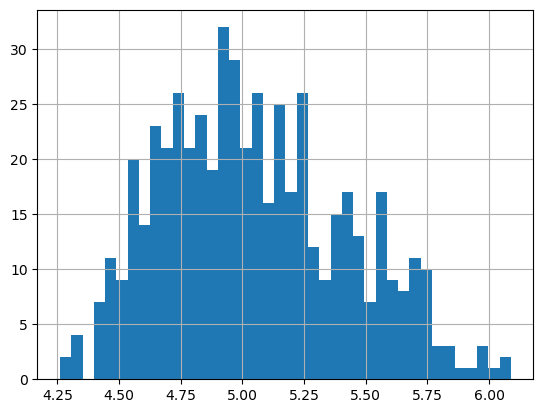

In [59]:
all_baselines['df_nfvae'].log_mq.hist(bins=40)

<Axes: >

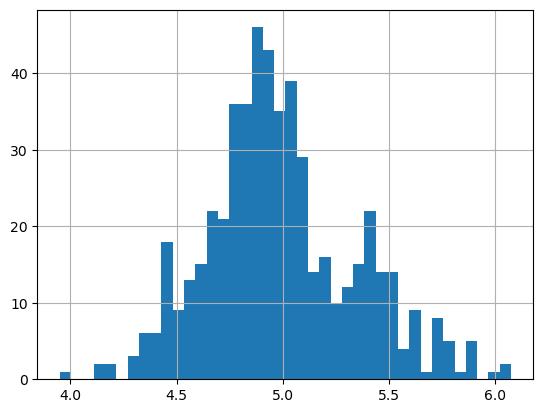

In [61]:
all_baselines['df_real'].log_mq.hist(bins=40)

In [40]:
saved_r2 = pd.read_csv('/data/housing/data/intermediate/regression_syn_homes/R2_df_no_nans.csv',index_col=0)

sum(saved_r2.df_copula_ablation<0)

16

In [43]:
saved_r2

,df_real,df_nfvae,df_ablation,df_copula_nf,df_copula_ablation,df_shuffle_province_num,df_shuffle_cap_num
AG,0.477977,0.247639,-0.049029,-0.478916,-3.589296,0.378617,0.459733
AL,0.558250,0.327935,0.341234,0.345711,0.366844,0.457355,0.546409
AN,0.607340,0.440512,-0.040399,0.442265,0.420393,0.318704,0.600772
AO,0.617387,0.365368,0.080200,0.371693,-11.291818,0.373919,0.604294
AP,0.583681,0.420003,-0.396421,0.313098,0.352180,0.388747,0.576345
...,...,...,...,...,...,...,...
VE,0.619318,0.185037,-0.694100,0.308046,-55143.935282,0.338996,0.615627
VI,0.668009,0.566740,0.411042,0.481308,0.488386,0.596886,0.660738
VR,0.652642,0.451727,-1.200953,0.424104,0.414902,0.335054,0.643561
VT,0.646643,0.430353,0.411535,-2.107159,0.430443,0.500214,0.638702


In [64]:
# boxplot
cols = list(saved_r2.columns)
cols = cols[1:]
cols

['df_nfvae',
 'df_ablation',
 'df_copula_nf',
 'df_copula_ablation',
 'df_shuffle_province_num',
 'df_shuffle_cap_num']

In [65]:
df_r2_plt = pd.DataFrame()
for col in cols:
    df_r2_plt[col] = saved_r2['df_real'] - saved_r2[col]

df_r2_plt

,df_nfvae,df_ablation,df_copula_nf,df_copula_ablation,df_shuffle_province_num,df_shuffle_cap_num
AG,0.230339,0.527006,0.956893,4.067273,0.099360,0.018244
AL,0.230315,0.217016,0.212540,0.191406,0.100896,0.011841
AN,0.166828,0.647739,0.165075,0.186947,0.288637,0.006568
AO,0.252019,0.537188,0.245695,11.909206,0.243468,0.013093
AP,0.163678,0.980102,0.270584,0.231502,0.194934,0.007336
...,...,...,...,...,...,...
VE,0.434281,1.313417,0.311272,55144.554600,0.280322,0.003690
VI,0.101269,0.256968,0.186701,0.179623,0.071123,0.007271
VR,0.200914,1.853595,0.228537,0.237740,0.317587,0.009081
VT,0.216290,0.235108,2.753802,0.216201,0.146430,0.007941


(0.0, 1.0)

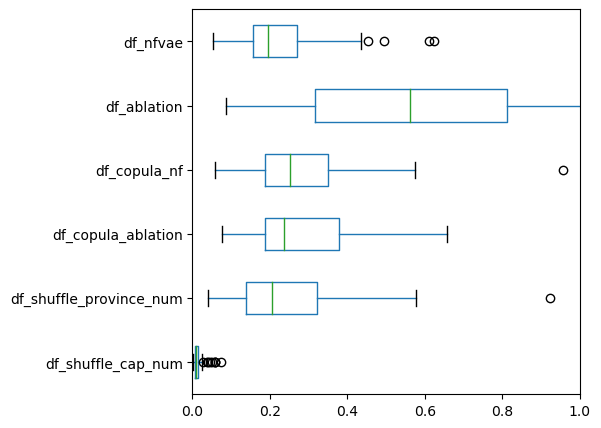

In [78]:
fig, ax = plt.subplots(figsize=(5,5))
ordine = ['df_shuffle_cap_num','df_shuffle_province_num','df_copula_ablation','df_copula_nf','df_ablation','df_nfvae']
df_r2_plt[ordine].boxplot(ax=ax, vert=False,grid=False)
ax.set_xlim([0,1])


In [71]:
df_r2_plt.describe()

,df_nfvae,df_ablation,df_copula_nf,df_copula_ablation,df_shuffle_province_num,df_shuffle_cap_num
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,0.223373,0.682409,2.064929,531.900490,0.238529,0.012995
std,0.108468,0.566152,7.987712,5355.627511,0.138180,0.013167
min,0.054115,0.086142,0.058048,0.076928,0.040220,0.000810
25%,0.156094,0.317213,0.186798,0.185913,0.137173,0.005758
50%,0.195950,0.560835,0.250763,0.237028,0.205977,0.008945
75%,0.270712,0.811941,0.349385,0.378636,0.321940,0.014672
max,0.623835,3.712241,58.615308,55144.554600,0.922404,0.074083


In [42]:
{col:sum(saved_r2[col]<0) for col in saved_r2.columns}

{'df_real': 0,
 'df_nfvae': 1,
 'df_ablation': 47,
 'df_copula_nf': 13,
 'df_copula_ablation': 16,
 'df_shuffle_province_num': 1,
 'df_shuffle_cap_num': 0}

In [55]:
trova = saved_r2.loc[saved_r2.df_nfvae<0,:]
trova

,df_real,df_nfvae,df_ablation,df_copula_nf,df_copula_ablation,df_shuffle_province_num,df_shuffle_cap_num
EN,0.505076,-0.11876,-0.124609,0.302356,0.255971,0.357671,0.467213


The code above does the regressions putting CAP dummies that represents fixed effects. The "problem" is that for the copula method sometimes the regression fails due to collinearity.

In [39]:
saved_r2

,Unnamed: 0,df_real,df_nfvae,df_ablation,df_copula_nf,df_copula_ablation,df_shuffle_province_num,df_shuffle_cap_num
0,AG,0.477977,0.247639,-0.049029,-0.478916,-3.589296,0.378617,0.459733
1,AL,0.558250,0.327935,0.341234,0.345711,0.366844,0.457355,0.546409
2,AN,0.607340,0.440512,-0.040399,0.442265,0.420393,0.318704,0.600772
3,AO,0.617387,0.365368,0.080200,0.371693,-11.291818,0.373919,0.604294
4,AP,0.583681,0.420003,-0.396421,0.313098,0.352180,0.388747,0.576345
...,...,...,...,...,...,...,...,...
101,VE,0.619318,0.185037,-0.694100,0.308046,-55143.935282,0.338996,0.615627
102,VI,0.668009,0.566740,0.411042,0.481308,0.488386,0.596886,0.660738
103,VR,0.652642,0.451727,-1.200953,0.424104,0.414902,0.335054,0.643561
104,VT,0.646643,0.430353,0.411535,-2.107159,0.430443,0.500214,0.638702


## Try at national scale

In [ ]:
italy_dict = {}

for file in tqdm(sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle'))):
    prov = file.split(".")[-2][-2:]
    # data loading
    with open(file, 'rb') as f:
        all_baselines = pickle.load(f)
    #print(len(all_baselines['df_real']))
    if prov == 'AG':
        italy_dict = all_baselines
    else:
        italy_dict = {key: pd.concat([italy_dict[key], all_baselines[key]], ignore_index=True) 
            for key in italy_dict.keys()}
        
    #print(len(italy_dict['df_real']))

        

In [ ]:
# spatial matching
key2keep = ['df_real','df_nfvae','df_ablation','df_copula_nf','df_copula_ablation','df_shuffle_province_num','df_shuffle_cap_num']
for  k in tqdm(key2keep):
    italy_dict[k] = utils.spatial_matching_ABM(italy_dict[k],
                                      hydro_risk = geo_dict["hydro_risk"],
                                      census = geo_dict["census"],
                                      omi_og = geo_dict["omi_og"],
                                      cap = geo_dict["cap"])

In [5]:
R2_dict = dict()

fix_eff = 'PRO_COM'

base_features = ['flag_garage', 'flag_pertinenza', 'flag_air_conditioning',
       'flag_multi_floor', 
       'log_mq', 'ANNO_COSTRUZIONE_1500_1965',
       'ANNO_COSTRUZIONE_1965_1985', 
       #'ANNO_COSTRUZIONE_1985_2005',
       'ANNO_COSTRUZIONE_2005_2025', 'ANNO_COSTRUZIONE_Missing',
       'High_energy_class', 'Low_energy_class', #'Medium_energy_class',
       'Missing_energy_class', 'COD_CAT_A02', 'COD_CAT_A03',
       'COD_CAT_A_01_07_08', #'COD_CAT_A_04_05', 
       #'floor_0.0', 
       'floor_1.0',
       'floor_2.0', 'floor_3.0', 'floor_Missing', 'floor_plus_4',
       'flag_air_conditioning_Missing', 'flag_multi_floor_Missing','PRO_COM']

base_features =' + '.join(base_features)
regr_formula = "log_price ~ "+base_features#+f" | {fix_eff}"


Idea to check if it works: try to add the col 'CAP' as a regressor. In this way, we are going 

In [ ]:
r = pf.feols(fml=regr_formula, data=italy_dict['df_nfvae'], drop_intercept=False,vcov = {"CRV1":fix_eff})

In [ ]:
italy_dict['df_nfvae']

In [ ]:
italy_dict['df_nfvae']

In [ ]:
r.predict(italy_dict['df_real'])

In [ ]:
print(r._fe)

In [ ]:
italy_dict['df_real'].CAP

In [ ]:
for k in tqdm(key2keep):
    
    if k == 'df_real':
        regr = pf.feols(fml=regr_formula, data=italy_dict[k], drop_intercept=False,vcov = {"CRV1":fix_eff})
        R2_dict[k] = regr._r2

        prova = regr.predict(italy_dict['df_nfvae'])
        
    else:
        real_data = italy_dict['df_real']
        syn_data = italy_dict[k]
        # Clean hidden characters
        syn_data['PRO_COM'] = (
            syn_data['PRO_COM']
            .astype(str)
            .str.strip()
            .str.replace(r'[\r\n\t]', '', regex=True)
            .str.replace(r'\s+', '', regex=True)   # remove all whitespace
            .str.normalize('NFKC')                 # normalize Unicode
        )

        real_data['PRO_COM'] = (
            real_data['PRO_COM']
            .astype(str)
            .str.strip()
            .str.replace(r'[\r\n\t]', '', regex=True)
            .str.replace(r'\s+', '', regex=True)
            .str.normalize('NFKC')
        )

        # Make sure categories align
        real_data['PRO_COM'] = pd.Categorical(real_data['PRO_COM'], categories=syn_data['PRO_COM'].unique())
        syn_data['PRO_COM'] = pd.Categorical(syn_data['PRO_COM'])
        

        syn_data = syn_data.loc[syn_data[fix_eff].isin(real_data[fix_eff].unique()),:]

        regr = pf.feols(fml=regr_formula, data=syn_data, drop_intercept=False,vcov = {"CRV1":fix_eff})


        italy_dict[k]["pred_price"] = regr.predict(real_data)

    del regr
                             


In [ ]:
(italy_dict['df_real'].PRO_COM=='001001').sum()

In [ ]:
(italy_dict['df_nfvae'].PRO_COM=='001001').sum()

In [ ]:
regr.summary()

In [ ]:
regr.fi

## Prova usando vecchie funzioni

In [10]:

def Train_RegressionHedonicPrice(train_data,test_data,sp_fix_eff):
    """
    Function to compute the hedonic price of the houses in the synthetic population
    Inputs:
     - train_data: ISP data
     - sp_fix_eff: spatial fixed effects (we start using PRO_COM)
     - save: flag that is True if you want to save the regression parameters in this file f'/data/housing/data/intermediate/HedonicRegressionABM/reg_risk_{sp_fix_eff}.pkl'. 

    Outputs:
     - reg_risk: regression objetc
    """

    # Drop colinearity variables
    drop_coliniarity= ['ANNO_COSTRUZIONE_1500_1965','Medium_energy_class',
                        'COD_CAT_A_04_05','floor_0.0','year_erogaz_2016']
    train_data = train_data.drop(columns=drop_coliniarity)

    # Add dummies to formula: 
    floor_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('floor_')]))
    year_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('year_erogaz_20')]))
    energy_class_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('_energy_class')]))
    ANNO_COSTRUZIONE_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('ANNO_COSTRUZIONE')]))
    COD_CAT_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('COD_CAT_')]))

    dummies_vec = COD_CAT_dummies + '+' + ANNO_COSTRUZIONE_dummies + '+' + energy_class_dummies + ' + ' + floor_dummies + '+' + year_dummies

    # Regression specification
    base_features = 'flag_garage + flag_pertinenza + flag_air_conditioning + flag_multi_floor +' + dummies_vec
    mq_feature = 'log_mq' 

    eq_regr_risk = 'log_price ~ scenario_Risk +' + mq_feature + '+' + base_features + '|' +  sp_fix_eff  # + C(month_erogaz) year_erogaz_prov +
    
    # Train regression
    reg_risk = pf.feols(fml=eq_regr_risk, data=train_data, drop_intercept=False ,vcov = {"CRV1":sp_fix_eff})

    test_data['log_price_estimation'] = reg_risk.predict(test_data)
    # Correct price estimations with Risk coefficient and average Inflation
    _, df_coeff = utils.ImportantCoefficients(reg_risk,['Risk'])

    return test_data, df_coeff




In [13]:
key2keep = ['df_real','df_nfvae','df_ablation','df_copula_nf','df_copula_ablation','df_shuffle_province_num','df_shuffle_cap_num']

R2_dict = pd.DataFrame()

fix_eff = 'OMI_id'

for file in tqdm(sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle'))):
#for prov in prov_list:

    prov = file.split(".")[-2][-2:]
    print(prov)
    #file = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'
    # data loading
    with open(file, 'rb') as f:
        all_baselines = pickle.load(f)

    for k in key2keep:
        all_baselines[k] = utils.spatial_matching_ABM(all_baselines[k],
                                      hydro_risk = geo_dict["hydro_risk"],
                                      census = geo_dict["census"],
                                      omi_og = geo_dict["omi_og"],
                                      cap = geo_dict["cap"])
        
        if k == 'df_real':
            regr = pf.feols(fml=regr_formula, data=all_baselines[k], drop_intercept=False,vcov = {"CRV1":fix_eff})
            R2_dict.loc[prov,k] = regr._r2
        else:
            try:
                all_baselines[k] = all_baselines[k].fillna(0)
                prov_test, df_coeff = Train_RegressionHedonicPrice(all_baselines[k],all_baselines['df_real'],fix_eff)
            except:
                print(prov,' regression faild, ',k)


  0%|          | 0/106 [00:00<?, ?it/s]

AG


  0%|          | 0/106 [00:00<?, ?it/s]


NanInClusterVarError: CRV inference not supported with missing values in the cluster variable.Please drop missing values before running the regression.